# Plot Results WebXR from Experiment
Author: Khushi Bhansali

This code is designed to analyze and visualize contrast sensitivity data from multiple experiments by processing and aggregating results from several JSON files. Each file compiles the experimental data, capturing information such as participant ID, spatial frequency, contrast threshold, maximum frequency, trial time, and the position of the visual target. Specifically, values for frequency, max frequency, and step are scaled by a factor of 26, while the size standard deviation is adjusted by a factor of 10. The JSON format also includes details about the target location and background noise, with all trial data stored in the `responses` array. The code combines this data across experiments, calculating the average contrast sensitivity for each unique combination of spatial frequency and target position. It then generates up to nine plots representing the Contrast Sensitivity Function (CSF) for different regions of the visual field, providing a clear visualization of the experimental outcomes.

**How to use this code effectively:**
Set the Folder Path: Replace the folder_path variable with the path to your folder containing the resulting JSON files from your experiments.


`folder_path = '/path/to/your/folder'`


**Run the Script:** Execute the script after setting the correct folder path.


**Interpret the Results:** The script will generate a figure with up to 9 subplots, each representing a different position in the visual field. These plots show how contrast sensitivity changes with spatial frequency for each position.

**What the Plots Show**


*   X-axis: Spatial Frequency (cycles/degree)

*   Y-axis: Contrast Sensitivity Function (CSF) on a logarithmic scale. Each plot represents a different position in the visual field.

*  The line in each plot shows the average contrast sensitivity across all processed files for that position.

This tool is valuable for researchers and clinicians studying visual perception, as it provides a comprehensive view of how contrast sensitivity varies across different spatial frequencies and positions in the visual field, aggregated from multiple experimental results.

---

**Run this cell to import nessecary dependencies for python code below**


In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

# Input the directory with the json files 

In [2]:
def get_directory_path():
    # Create a root window but hide it
    root = tk.Tk()
    root.withdraw()  # Hide the root window

    # Open a directory dialog and let the user select a directory
    directory_path = filedialog.askdirectory(title="Select a Directory")
    
    return directory_path

# Call the function and print the selected directory path
folder_path = get_directory_path()
print(f"Selected directory: {folder_path}")

Selected directory: C:/Users/MohammadAbuB.Akhonda/OneDrive - FDA/Documents/Work/Project/Chumin_WebXR


# Plot contrast sensitivity graphs

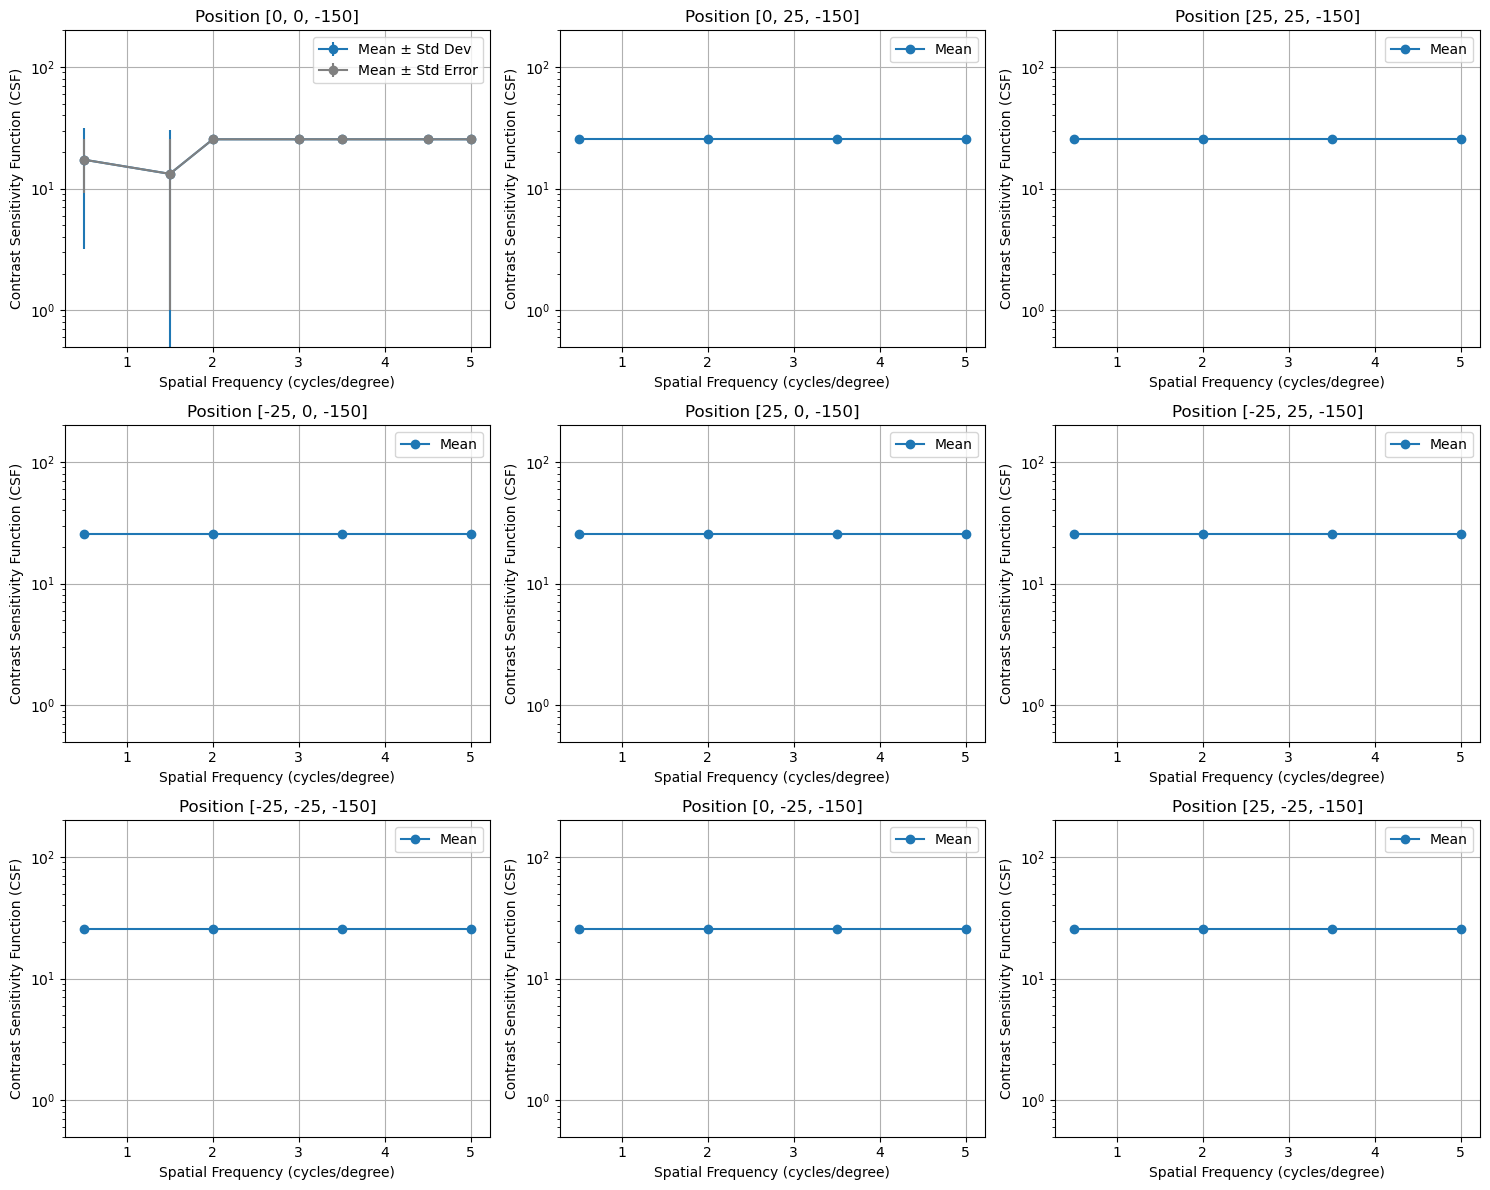

In [6]:
def openFile(path):
    with open(path, 'r') as f:
        return json.loads(f.read())

def reorder(df_nested_list):

    # Convert position to string and then check for unique values
    positions = df_nested_list['position'].astype(str).unique()

    # If more than one position, drop the first row
    if len(positions) > 1:
        df_nested_list = df_nested_list.iloc[1:].reset_index(drop=True)


    n = len(df_nested_list)
    for index, row in df_nested_list.iterrows():
        if (index-1)%9 == 0 and index+4 < n:
            center = df_nested_list.loc[index].values
            df_nested_list.loc[index] = df_nested_list.loc[index+1].values
            df_nested_list.loc[index+1] = df_nested_list.loc[index+2].values
            df_nested_list.loc[index+2] = df_nested_list.loc[index+3].values
            df_nested_list.loc[index+3] = df_nested_list.loc[index+4].values
            df_nested_list.loc[index+4] = center
    return df_nested_list

def process_file(file_path):
    data = openFile(file_path)
    df_nested_list = pd.json_normalize(data, record_path=['responses'])
    df_nested_list = reorder(df_nested_list)

    df_combined = df_nested_list[["frequency", "position", "contrast"]].copy()
    df_combined.loc[:, 'position'] = df_combined["position"].map(str)
    df_combined.loc[:, 'frequency'] = df_combined['frequency'].map(float)
    df_combined.loc[:, 'contrast'] = df_combined['contrast'].map(float)
    df_combined.loc[:, 'contrast'] = 1 / df_combined['contrast']

    return df_combined

def plot_results(df_combined):
    positions = df_combined['position'].unique()
    num_positions = len(positions)

    # Determine the grid size based on the number of positions
    if num_positions <= 1:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        axes = [ax]
    else:
        rows = int(np.ceil(np.sqrt(num_positions)))
        cols = int(np.ceil(num_positions / rows))
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        axes = axes.flatten()

    for i, position in enumerate(positions):
        ax = axes[i]
        subset = df_combined[df_combined['position'] == position]

        # Group by frequency and calculate mean, std, and standard error
        stats = subset.groupby('frequency')['contrast'].agg(['mean', 'std', 'count'])
        stats['stderr'] = stats['std'] / np.sqrt(stats['count'])

        # Check if there's more than one data point per frequency
        multiple_data_points = (stats['count'] > 1).any()

        if not stats.empty and not stats['std'].isnull().all() and multiple_data_points:
            # Plot with error bars for standard deviation and standard error
            ax.errorbar(stats.index, stats['mean'], yerr=stats['std'], fmt='o-', label='Mean ± Std Dev')
            ax.errorbar(stats.index, stats['mean'], yerr=stats['stderr'], fmt='o-', label='Mean ± Std Error', color='gray')
            #ax.errorbar(stats.index, stats['mean'], yerr=stats['stderr'], fmt='o-', label='Mean ± Std Error', linestyle='--', color='gray')
        else:
            # Plot without error bars if no variation in data
            ax.plot(stats.index, stats['mean'], 'o-', label='Mean')

        ax.set_xlabel('Spatial Frequency (cycles/degree)')
        ax.set_ylabel('Contrast Sensitivity Function (CSF)')
        ax.set_yscale('log')
        ax.set_ylim(0.5, 200)
        ax.set_title(f'Position {position}')
        ax.grid(True)
        ax.legend()

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
# Main execution
all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        df = process_file(file_path)
        all_dfs.append(df)

# Concatenate all dataframes
df_combined = pd.concat(all_dfs, ignore_index=True)

# Plot the results and get the figure
fig = plot_results(df_combined)


In [7]:
pip install pyinstaller

Note: you may need to restart the kernel to use updated packages.


In [10]:
pyinstaller --onefile "AnalyzeResults.py"

SyntaxError: invalid syntax (1623671940.py, line 1)